# CNN for Mnist handwritten numeral recognition

In [4]:
import torch
import torchvision     
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable

import matplotlib.pyplot as plt

# torch.manual_seed(1)   

### 1.Mnist 数据集 

In [7]:
DOWNLOAD_MNIST = False  
'''Mnist 手写数字数据集'''

# 训练数据
train_data = torchvision.datasets.MNIST(
    root="./mnist/",   
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(), #数据转换为torch.FloatTensor (C x H x W)
    download=DOWNLOAD_MNIST        
)

# 测试数据
test_data = torchvision.datasets.MNIST(root="./mnist/", 
                                       train=False)
 
print('#train_data:', len(train_data))
print('#test_data:', len(test_data))

print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)

#train_data: 60000
#test_data: 10000
torch.Size([60000, 28, 28])
torch.Size([60000])


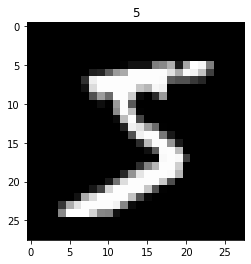

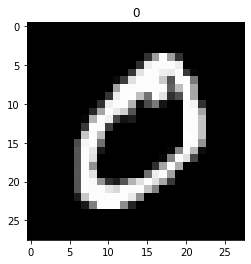

In [21]:
# plot one example
for i in range(2):
    plt.imshow(train_data.train_data[i].numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[i])
    plt.show()

### 2. 构造 Dataloader 

In [23]:
# batch, 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, 
                               batch_size=52, 
                               shuffle=True)
 
# 测试前2000个
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

### 3. Convolutional Neural Networks Model

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input shape (1, 28, 28)
        self.conv1 = nn.Sequential( 
            nn.Conv2d(
                in_channels=1,      # input height
                out_channels=16,    # n_filters
                kernel_size=5,      # filter size
                stride=1,           # filter movement/step
                padding=2,      # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
            ),      # output shape (16, 28, 28)
            nn.ReLU(),    # activation
            nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        
        self.conv2 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes
 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x
 

### 4. 训练模型 

In [37]:
learning_rate = 0.001
epochs = 1

model = CNN()
print('{} Model Architecture {}'.format('='*30, '='*30))
print(model)  

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

============================== Model Architecture ==============================
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [38]:
# training and testing
print('{} Training and Testing {}'.format('='*30, '='*30))
for epoch in range(epochs):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        output = model(batch_x)[0]              
        loss = loss_func(output, batch_y)  
        optimizer.zero_grad()        
        loss.backward()               
        optimizer.step()        
        
        if step % 100 == 0:
            #测试数据
            test_output, last_layer = model(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum())/float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

============================== Training and Testing ==============================
Epoch:  0 | train loss: 2.3067 | test accuracy: 0.12
Epoch:  0 | train loss: 0.3834 | test accuracy: 0.86
Epoch:  0 | train loss: 0.2560 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0468 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0872 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0397 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0369 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0272 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0627 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0457 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0641 | test accuracy: 0.98
Epoch:  0 | train loss: 0.1443 | test accuracy: 0.98


### 5. 测试 & 可视化

In [39]:
test_output, test_x_output = model(test_x)
pred_y = torch.max(test_output, 1)[1].data.numpy()

print('#predictions\t', pred_y[:20])
print('#ground truth\t', test_y[:20].numpy())

#predictions	 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
#ground truth	 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [45]:
test_x_output.data.numpy().shape

(2000, 1568)

In [44]:
from sklearn.manifold import TSNE

# 降维
tsne = TSNE(perplexity=30, 
            n_components=2, 
            init='pca', 
            n_iter=1000)

plot_only = 500
low_dim_embs = tsne.fit_transform(test_x_output.data.numpy()[:plot_only,:])
labels = test_y.numpy()[:plot_only]

print('#low_dim_embs.shape:', low_dim_embs.shape)
print('#labels.shape:', labels.shape)

#low_dim_embs.shape: (500, 2)
#labels.shape: (500,)


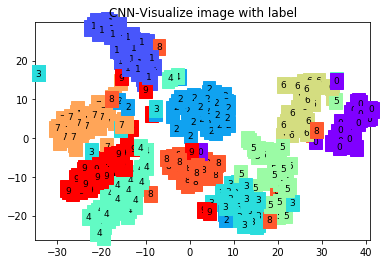

In [42]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.cla()
X, Y = low_dim_embs[:, 0], low_dim_embs[:, 1]
for x, y, s in zip(X, Y, labels):
    c = cm.rainbow(int(255*s/9)); 
    plt.text(x, y, s, backgroundcolor=c, fontsize=9)

plt.xlim(X.min(), X.max()) 
plt.ylim(Y.min(), Y.max())
plt.title('CNN-Visualize image with label')
plt.show()
plt.pause(0.01)